In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
import missingno as msno

filterwarnings('ignore')

# https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/80/

#About 10 day lags & live 50 days
#-------------------------------
# Larvae 1~2 days
# Pupae Within 7~10 days
# The average adult female mosquito can live up to 42-56 days
# Given this - it's likely a TimeSeries problem
# Also, Not sure why splitting the data to SJ or IQ makes real difference

# Have missing data so forward fill = ffill & 
# week_start_date is duplicated by week number

## Loading Data

In [2]:
# Loading CSV & dropping "week_start_date" as I have other time marker like 
df_train_y = pd.read_csv('./dengue_labels_train.csv', index_col=[0, 1, 2])
df_train_x = pd.read_csv('./dengue_features_train.csv', index_col=[0, 1, 2]).drop('week_start_date', axis=1)
df_test_x = pd.read_csv('./dengue_features_test.csv',  index_col=[0, 1, 2]).drop( 'week_start_date', axis=1)

# checking to making sure columns names & columnames train vs. test
print(df_train_x.columns)
print(df_test_x.columns == df_train_x.columns)

Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k',
       'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


### Converting Kelvin measurement to Celsius as I lack intuition about Kelvin

In [3]:
def convert_kelvin_to_celsius(X):
    # List of columns in Kelvin 
    convert_to_celsius = [f_name for f_name in X.columns if re.match('^reanalysis.+k$',f_name)]
    # Converting Kelvin to Celsius
    X[convert_to_celsius] -= 273.15
     # Replacing column names with K to C suffix
    X.columns = [re.sub('^reanalysis.+k$',f_name[:-1]+'c',f_name) for f_name in X.columns]
    return X

df_train_x = convert_kelvin_to_celsius(df_train_x)
df_test_x = convert_kelvin_to_celsius(df_test_x)

print(df_train_x.columns)

Index(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
       'reanalysis_air_temp_c', 'reanalysis_avg_temp_c',
       'reanalysis_dew_point_temp_c', 'reanalysis_max_air_temp_c',
       'reanalysis_min_air_temp_c', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_c',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')


## Missing value counts & visualization

Count of Nulls per features
ndvi_ne                    194
ndvi_nw                     52
station_diur_temp_rng_c     43
station_avg_temp_c          43
ndvi_sw                     22
dtype: int64


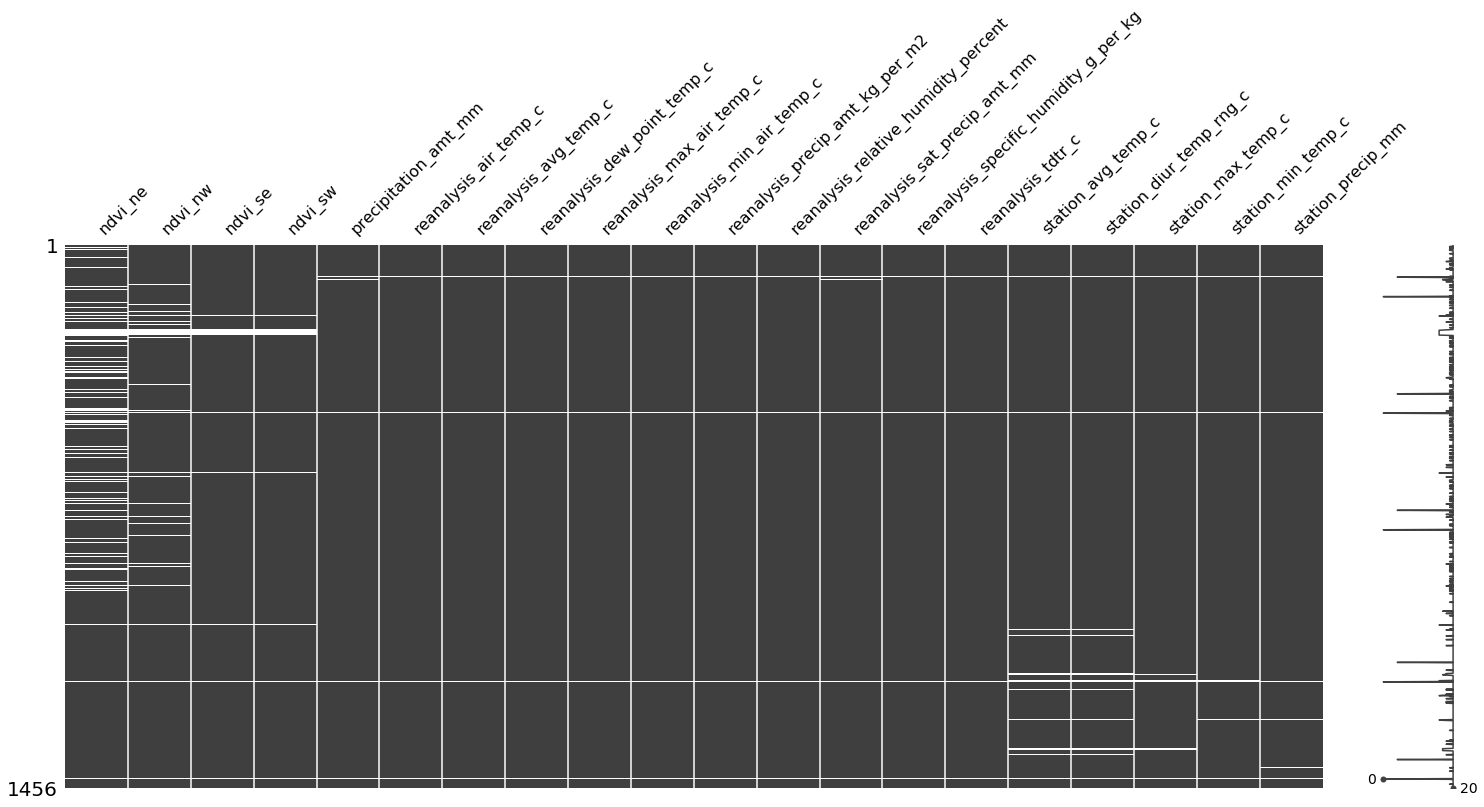

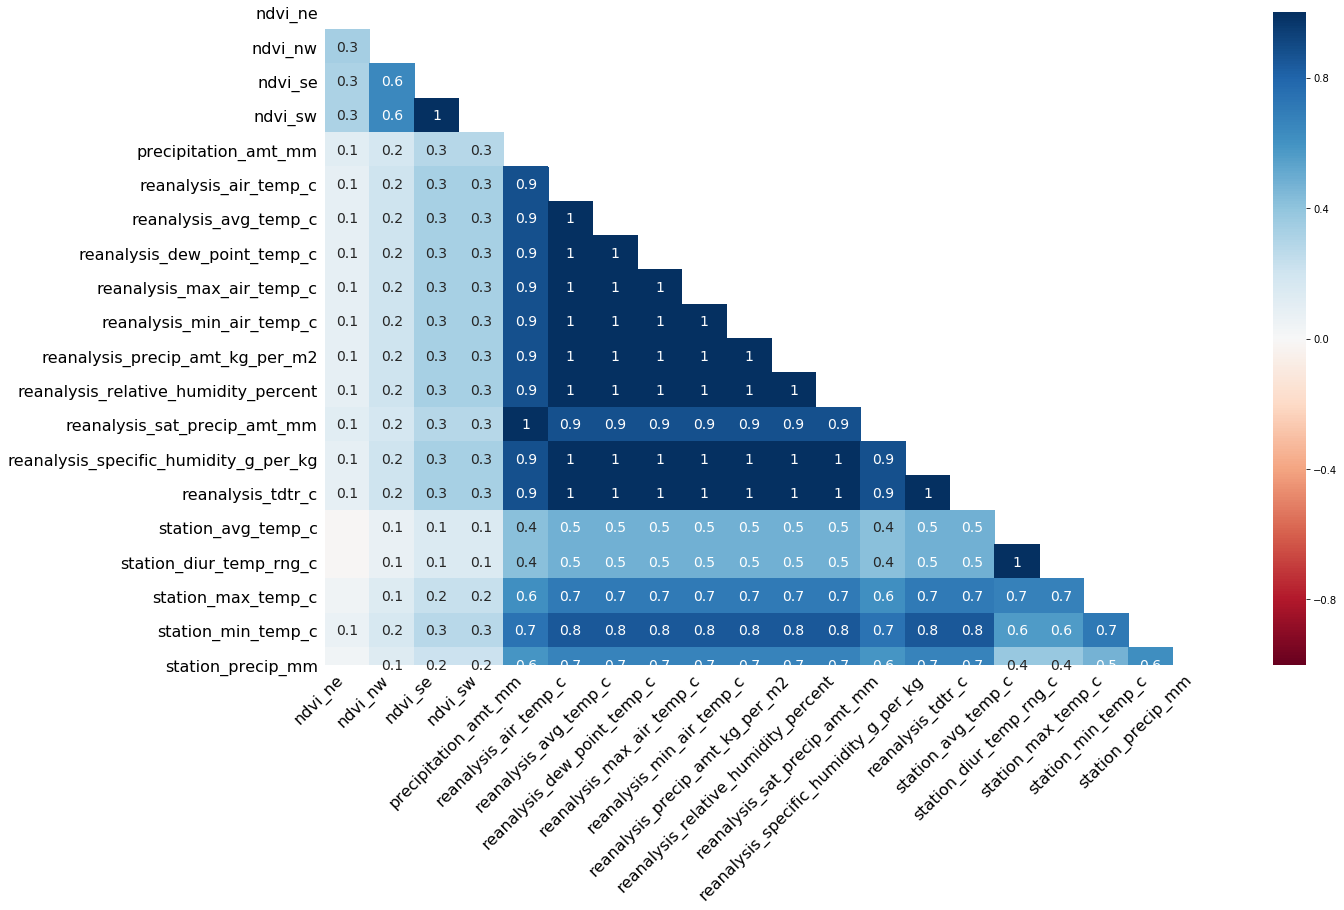

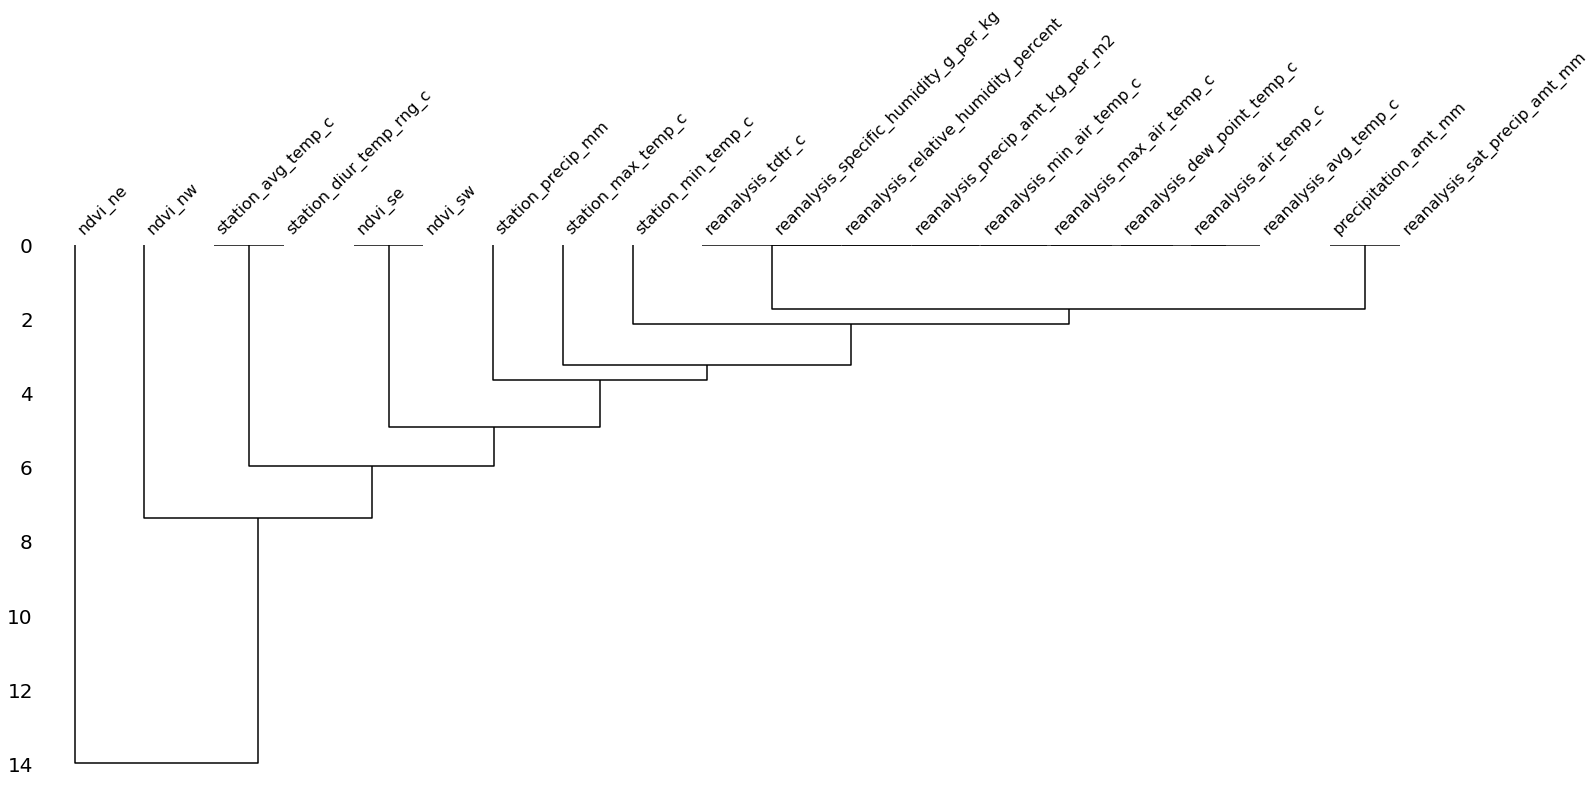

In [4]:
print('Count of Nulls per features')
print(df_train_x.isnull().sum(axis=0).sort_values(ascending=False).head())

msno.matrix(df_train_x)
msno.heatmap(df_train_x)
msno.dendrogram(df_train_x)
#msno.matrix(df_test_x)

In [5]:
# Filling prev value for Missing value
df_train_x.fillna(method='ffill', inplace=True)
df_test_x.fillna(method='ffill', inplace=True)
print(df_train_x.isnull().sum(axis=0).sort_values(ascending=False).head())

station_precip_mm     0
station_min_temp_c    0
ndvi_nw               0
ndvi_se               0
ndvi_sw               0
dtype: int64


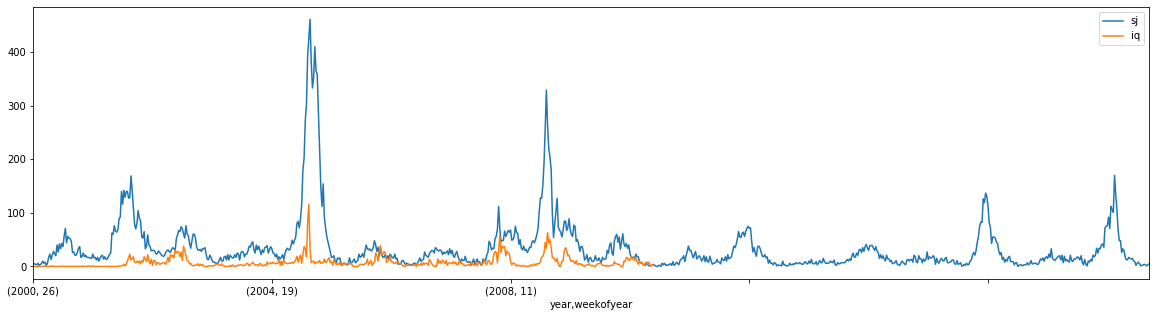

count SJ: 936   IQ: 520
Above shows iq has abouit 1/2 count of sj


In [6]:
# Quick Graph to show total_cases 
plt.figure(figsize = (20, 5))
(df_train_y.loc['sj']
     .total_cases
     .plot(label='sj'))
(df_train_y.loc['iq']
     .total_cases
     .plot(label='iq'))
plt.legend()
plt.show()
# Graph show pretty strong correlation 

print("count SJ: {}   IQ: {}".format(df_train_y.loc['sj'].shape[0], df_train_y.loc['iq'].shape[0]))
print("Above shows iq has abouit 1/2 count of sj")

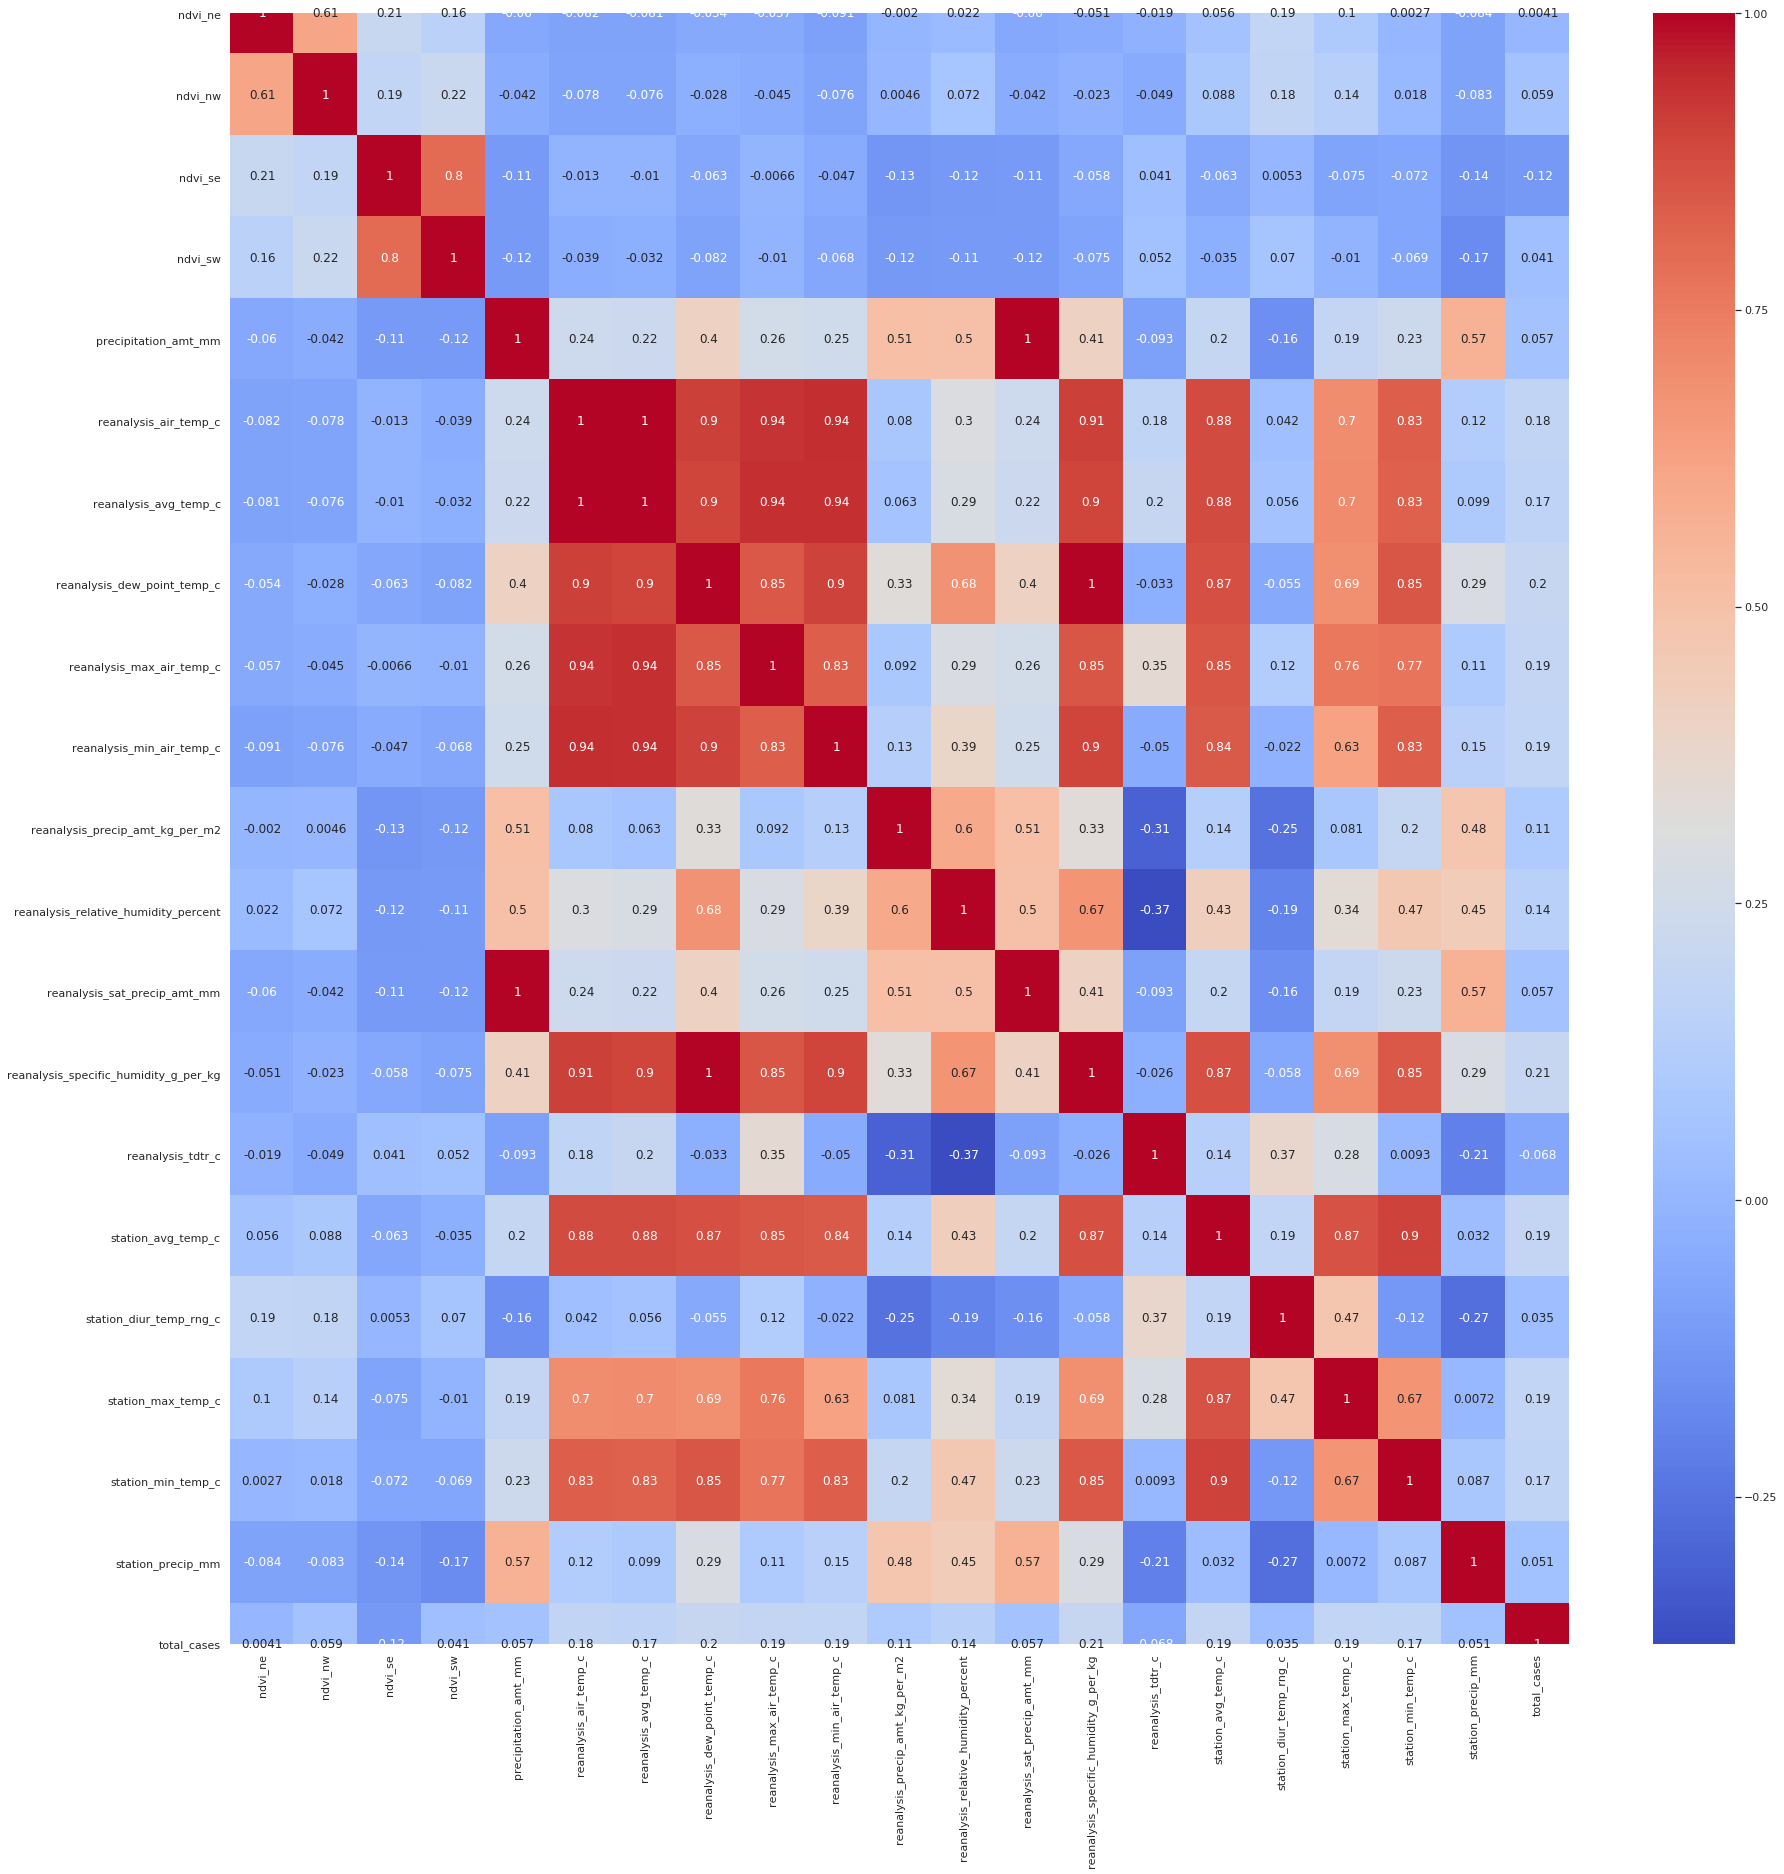

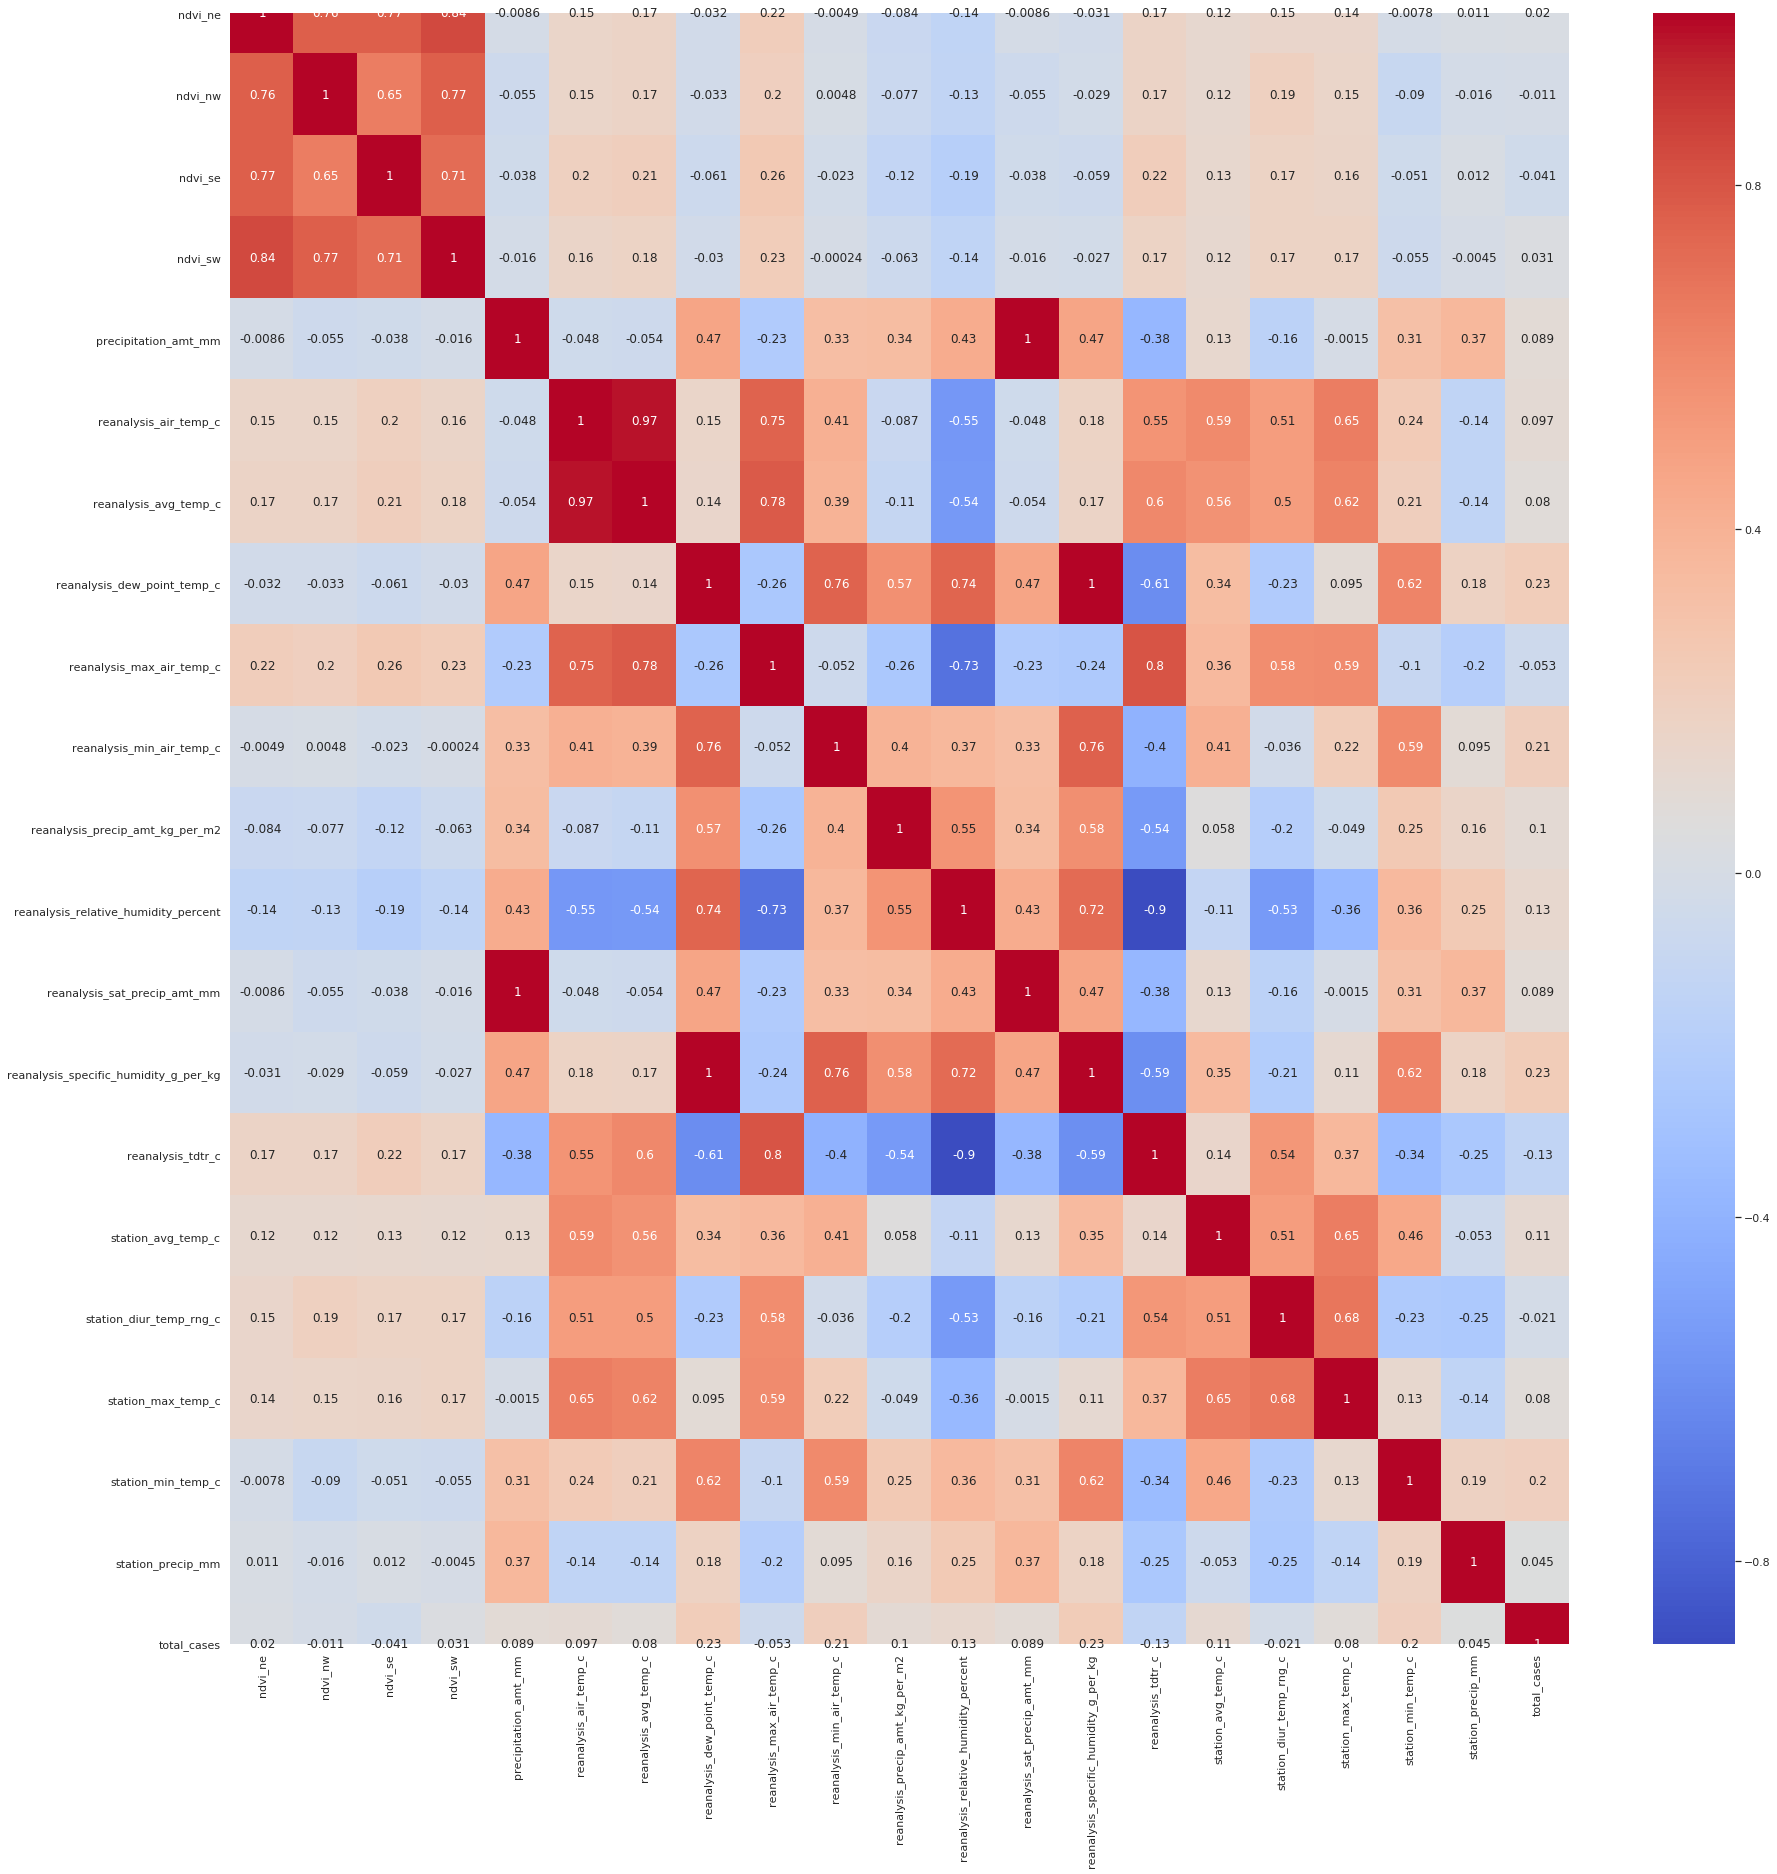

In [7]:
sj_tmp_x = df_train_x.loc['sj']
sj_tmp_x['total_cases'] = df_train_y.loc['sj']['total_cases'] 
sj_x_corr = sj_tmp_x.corr() 

sns.set(font_scale=1)
plt.figure(figsize=(30, 30))
sns.heatmap(sj_x_corr, cmap='coolwarm', annot=True)
plt.show()

iq_tmp_x = df_train_x.loc['iq']
iq_tmp_x['total_cases'] = df_train_y.loc['iq']['total_cases'] 
iq_x_corr = iq_tmp_x.corr() 

sns.set(font_scale=1)
plt.figure(figsize=(30, 30))
sns.heatmap(iq_x_corr, cmap='coolwarm', annot=True)
plt.show()

Features do NOT show high correlation looking at the colors